## Exercise

Dataset `/m/jhnas/jupyter/shareddata/python-r-data-analysis/honey-production/honeyproduction.csv` contains data on honey production in the US.

1. Calculate the total amount of honey produced in the US for each year. Plot it.
2. For each state, fit a linear model totalprod ~ year. Plot original data and fitted lines.
3. Plot the slope coefficient of the linear fit.

Loading required packages.

In [1]:
library(tidyverse)
if (!file.exists('rlibs')) {
    dir.create('rlibs')
}
if (!file.exists('rlibs/broom')) {
    install.packages('broom', repos="http://cran.r-project.org", lib='rlibs')
}
if (!file.exists('rlibs/gapminder')) {
    install.packages('gapminder', repos="http://cran.r-project.org", lib='rlibs')
}
library(broom, lib.loc='rlibs')
library(gapminder, lib.loc='rlibs')
library(modelr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘modelr’


The following object is masked from ‘package:broom’:

    bootstrap




Loading data.

In [2]:
honey <- read_csv("/m/jhnas/jupyter/shareddata/python-r-data-analysis/honey-production/honeyproduction.csv")

Parsed with column specification:
cols(
  state = col_character(),
  numcol = col_double(),
  yieldpercol = col_double(),
  totalprod = col_double(),
  stocks = col_double(),
  priceperlb = col_double(),
  prodvalue = col_double(),
  year = col_double()
)



Calculate yearly production using `summarize`.

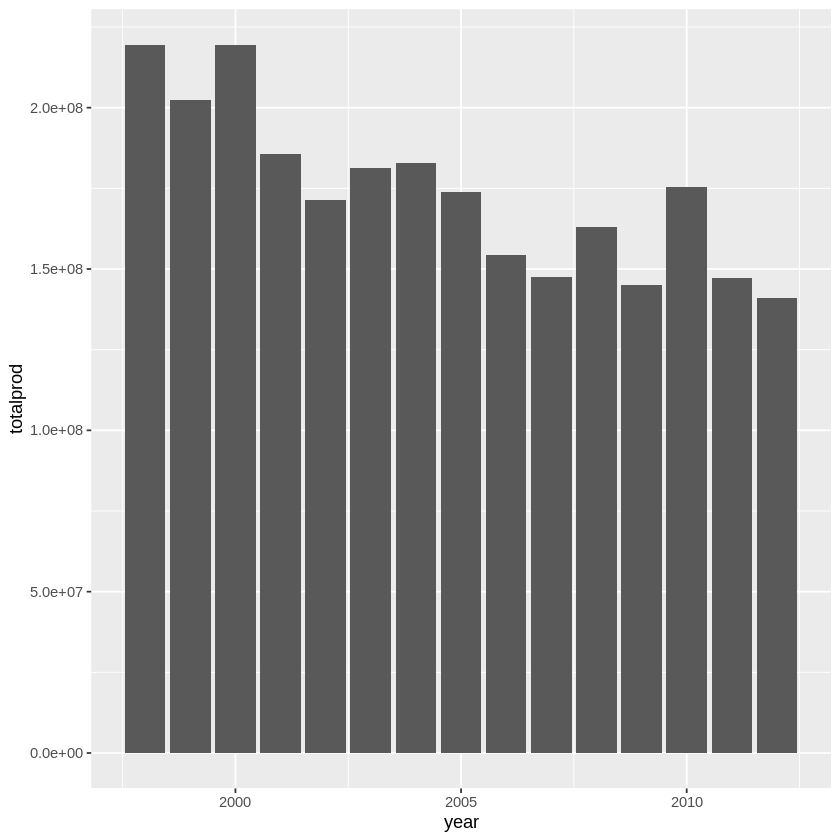

In [3]:
yearly_prod <- honey %>%
    select(year,totalprod) %>%
    group_by(year) %>%
    summarize(totalprod=sum(totalprod))

yearly_prod %>%
    ggplot(aes(x=year, y=totalprod)) +
        geom_col()

Create a nested array with the relevant variables.

In [4]:
honey_nested <- honey %>%
    select(state, totalprod, year) %>%
    group_by(state) %>%
    nest()

Create a model function.

In [5]:
honey_model <- function(data) lm(totalprod ~ year, data=data)

Fit the models using `map` and `mutate`.

In [6]:
honey_nested <- honey_nested %>%
    mutate(
        models=map(data, honey_model)
    )

Add predictions using `map2` and `mutate`.

In [7]:
honey_nested <- honey_nested %>%
    mutate(
        pred=map2(data, models, add_predictions)
    )

Unnest predictions.

In [8]:
honey_predictions <- unnest(honey_nested, pred)
head(honey_predictions)

state,totalprod,year,pred
<chr>,<dbl>,<dbl>,<dbl>
AL,1136000,1998,1268666.7
AL,1156000,1999,1205352.4
AL,1248000,2000,1142038.1
AL,1022000,2001,1078723.8
AL,1032000,2002,1015409.5
AL,1066000,2003,952095.2


Plot predictions.

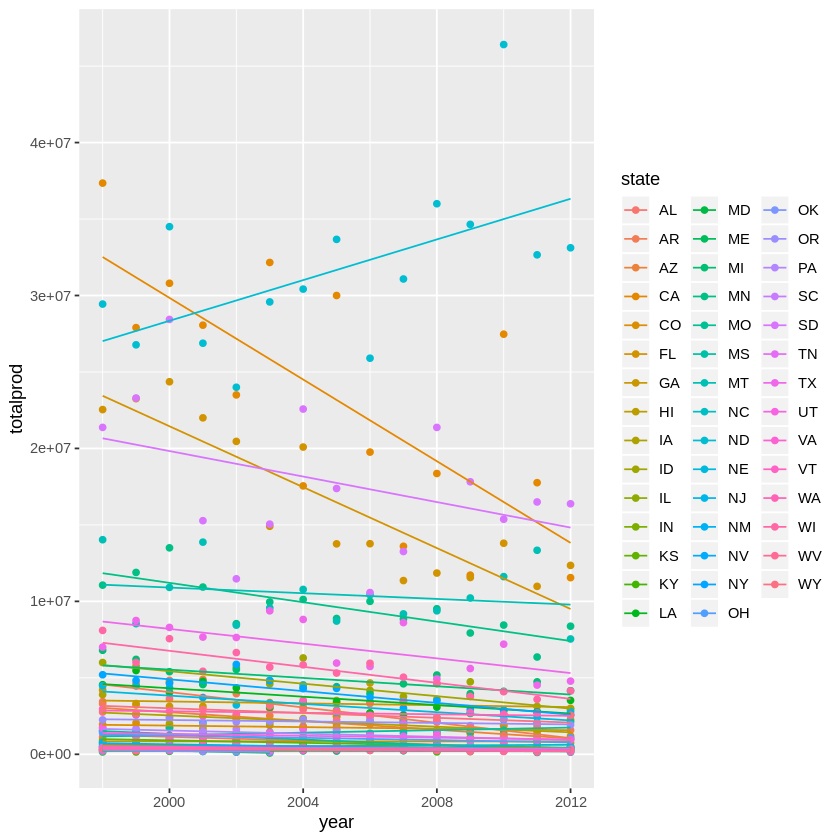

In [9]:
honey_predictions %>%
    ggplot(aes(x=year, y=totalprod, color=state)) +
        geom_point() +
        geom_line(aes(y=pred))

Use `map` and `tidy` to obtain model parameters.

In [10]:
honey_nested <- honey_nested %>%
    mutate(
        model_params=map(models, tidy)
    )

Unnest the model parameters.

In [11]:
honey_model_params <- honey_nested %>%
    unnest(model_params)

Plot the model parameters.

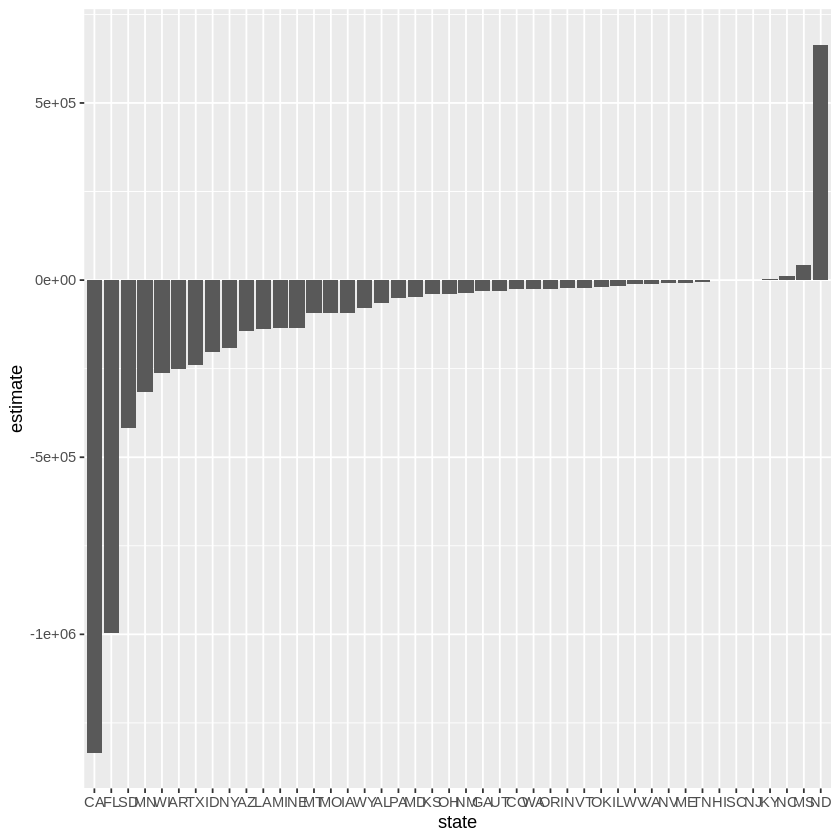

In [12]:
honey_model_params %>%
    filter(term=='year') %>%
    mutate(state=reorder(state,estimate)) %>%
    ggplot(aes(x=state,y=estimate)) +
        geom_col()